# Developing an AI application

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

## Load the data

In [ ]:
data_dir = '../drive/Shareddrives/Reconnaissance_image_Fleurs/PyTorch_Image_Classifier_master/flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid/'
test_dir = data_dir + '/test/'

In [ ]:
# training, validation, et testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# Load de datasets avec ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# Definition des dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)

### Label mapping


In [ ]:
# Importation du fichier JSON 
import json
json_dict='/content/drive/Shareddrives/Reconnaissance_image_Fleurs/PyTorch_Image_Classifier_master/flower_to_name.json'
with open(json_dict, 'r') as f:
    flower_to_name = json.load(f)
    
print(len(flower_to_name)) 
print(flower_to_name)

102
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54'

# Building and training the classifier

In [ ]:
# Création du modèle prédéfini et pré-entrainé VGG 16, avec une redéfinition de la partie classification
model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for parameter in model.parameters():
    parameter.requires_grad = False


from collections import OrderedDict

# Redéfinition du classifier du modèle
classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                        ('relu', nn.ReLU()),
                                        ('drop', nn.Dropout(p=0.5)),
                                        ('fc2', nn.Linear(5000, 102)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

In [ ]:
# Fonction de validation
def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy

In [ ]:
# Fonction de coût et d'optimisation de gradients

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [ ]:
# Fonction de train

from workspace_utils import active_session

def train_classifier():
  
  with active_session():

      epochs = 15
      steps = 0
      print_every = 40

      model.to('cuda')

      for e in range(epochs):
      
          model.train()
  
          running_loss = 0
  
          for images, labels in iter(train_loader):
      
              steps += 1
      
              images, labels = images.to('cuda'), labels.to('cuda')
      
              optimizer.zero_grad()
      
              output = model.forward(images)
              loss = criterion(output, labels)
              loss.backward()
              optimizer.step()
      
              running_loss += loss.item()
      
              if steps % print_every == 0:
              
                  model.eval()
              
                  # Arreter le calcul de gradients pour la validation
                  with torch.no_grad():
                      validation_loss, accuracy = validation(model, validate_loader, criterion)
          
                  print("Epoch: {}/{}.. ".format(e+1, epochs),
                        "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                        "Validation Loss: {:.3f}.. ".format(validation_loss/len(validate_loader)),
                        "Validation Accuracy: {:.3f}".format(accuracy/len(validate_loader)))
          
                  running_loss = 0
                  model.train()
                  
train_classifier()                    

## Testing your network

In [ ]:
def test_accuracy(model, test_loader):

    model.eval()
    model.to('cuda')

    with torch.no_grad():
    
        accuracy = 0
    
        for images, labels in iter(test_loader):
    
            images, labels = images.to('cuda'), labels.to('cuda')
    
            output = model.forward(images)

            probabilities = torch.exp(output)

            equality = (labels.data == probabilities.max(dim=1)[1])
        
            accuracy += equality.type(torch.FloatTensor).mean()
        
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
        
        
test_accuracy(model, test_loader)

Test Accuracy: 0.9005566835403442


## Save the checkpoint

In [ ]:
# Save the checkpoint pour avoir les meilleurs paramètres du modèle

def save_checkpoint(model):

    model.class_to_idx = training_dataset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(model)    

## Loading the checkpoint


In [ ]:
from collections import OrderedDict

def load_checkpoint(filepath):
    
    checkpoint = torch.load(filepath)
    
    if checkpoint['arch'] == 'vgg16':
        
        model = models.vgg16(pretrained=True)
        
        for param in model.parameters():
            param.requires_grad = False
    else:
        print("Architecture not recognized.")
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    classifier = nn.Sequential(OrderedDict([('fc1', nn.Linear(25088, 5000)),
                                            ('relu', nn.ReLU()),
                                            ('drop', nn.Dropout(p=0.5)),
                                            ('fc2', nn.Linear(5000, 102)),
                                            ('output', nn.LogSoftmax(dim=1))]))

    model.classifier = classifier
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

#model = load_checkpoint('checkpoint.pth')
#print(model)

# Inference for classification

In [ ]:
from PIL import Image

def process_image(image_path):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model
    
    pil_image = Image.open(image_path)
    
    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))
        
    # Crop 
    left_margin = (pil_image.width-224)/2
    bottom_margin = (pil_image.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))
    
    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array
    # Color channel needs to be first; retain the order of the other two dimensions.
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

In [ ]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    image = process_image(image_path)
    
    # Conversion de l'image à PyTorch tensor 
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    #print(image.shape)
    #print(type(image))
    
    # Returns a new tensor with a dimension of size one inserted at the specified position.
    image = image.unsqueeze(0)
    
    output = model.forward(image)
    
    probabilities = torch.exp(output)
    
    # Probabilités aet indices des classes correspondantes
    top_probabilities, top_indices = probabilities.topk(topk)
    
    # Convertir en listes
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0] 
    
    # Convertir top_probabilities au noms de classes des images 
    
    idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #print(idx_to_class)
    
    top_classes = [idx_to_class[index] for index in top_indices]
    
    return top_probabilities, top_classes
    
probs, classes = predict('flowers/test/15/image_06369.jpg', model)   
print(probs)
print(classes)

[1.0, 1.584775422003304e-09, 3.365227194129794e-11, 1.1008217720622632e-13, 1.0215112311801403e-13]
['15', '42', '90', '83', '50']


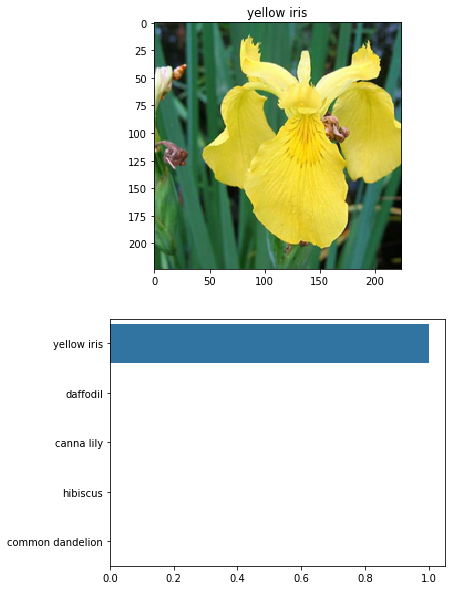

In [ ]:
# Test avec une image et plot des probabilités 
plt.figure(figsize = (6,10))
plot_1 = plt.subplot(2,1,1)

image = process_image('flowers/test/15/image_06369.jpg')

flower_title = flower_to_name['15']

imshow(image, plot_1, title=flower_title);

flower_names = [flower_to_name[i] for i in classes]

plt.subplot(2,1,2)

sb.barplot(x=probs, y=flower_names, color=sb.color_palette()[0]);

plt.show()